In [1]:
import pandas as pd
import numpy as np
import cv2
import keras

2023-01-16 16:49:08.031710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 16:49:08.793669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karan/Secondary/dev/ml/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-16 16:49:08.793725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-16 16:49:08.877326: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when o

In [2]:
CSV_FILE = r"data/csv/road_classification.csv"

features = pd.read_csv(CSV_FILE)

features.head(10)

,file_name,normal,negative,positive
0,data/final_data/1.jpg,0,2,0
1,data/final_data/10.jpg,0,1,0
2,data/final_data/100.jpg,1,0,0
3,data/final_data/101.jpg,1,0,0
4,data/final_data/102.jpg,1,0,0
5,data/final_data/103.jpg,0,3,0
6,data/final_data/104.jpg,1,0,0
7,data/final_data/105.jpg,1,0,0
8,data/final_data/106.jpg,1,0,0
9,data/final_data/107.jpg,1,0,0


In [3]:
features.isna().sum()

file_name    0
normal       0
negative     0
positive     0
dtype: int64

In [4]:
from sklearn.utils import shuffle

img_names = features['file_name']
labels = features.drop('file_name', axis=1)

img_names_shuffled, labels_shuffled = shuffle(img_names, labels)

In [5]:
from sklearn.model_selection import train_test_split

X_train_img, X_test_img, y_train, y_test = train_test_split(
    img_names_shuffled, labels_shuffled,
    test_size=0.2,
    random_state=101
)

In [6]:
train_class = y_train[['normal', 'negative', 'positive']]
test_class = y_test[['normal', 'negative', 'positive']]

train_class = np.array(train_class)
test_class = np.array(test_class)

In [7]:
y_train.shape

(260, 3)

In [8]:
def get_img_by_loc(location: str) -> cv2.Mat:
    img = cv2.imread(location)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255
    img = cv2.resize(img, (64,64))
    return img

In [9]:
class ImageGenerator(keras.utils.Sequence):

    def __init__(self, img_files, img_class_num, batch_size = 32) -> None:
        self.img_files = img_files
        self.img_class_num = img_class_num
        self.batch_size = batch_size

    
    def __len__(self):
        return int((np.ceil(len(self.img_files) / float(self.batch_size))))
    
    
    def __getitem__(self, idx):
        batch_x = self.img_files[idx * self.batch_size : (idx + 1) * self.batch_size]
        first = self.img_class_num[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = np.array(first)

        return np.array([
            get_img_by_loc(f'{file_name}')
            for file_name in batch_x
        ]), batch_y

In [10]:
batch_size = 32

train_batch_gen = ImageGenerator(X_train_img, train_class, batch_size)
test_batch_gen  = ImageGenerator(X_test_img, test_class, batch_size)

In [11]:
import tensorflow
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Activation, Add, BatchNormalization

In [12]:
input_ = Input(shape=(64,64,1), name="Input Layer")

conv_1 = Conv2D(32, kernel_size= (4, 4), name="conv_1")(input_)
act_1  = Activation("relu", name="act_1")(conv_1)
pool_1 = MaxPooling2D(pool_size=(8, 8), strides=(1,1), padding="valid", name="pool_1")(act_1)

conv_2 = Conv2D(64, kernel_size = (8, 8), name = "conv_2")(pool_1)
act_2 = Activation("relu", name = "act_2")(conv_2)
pool_2 = MaxPooling2D(pool_size = (4, 4), strides = (1, 1), padding = "valid", name = "pool_2")(act_2)

flat_1 = Flatten(name = "flat_1")(pool_2)

dense_1 = Dense(128, activation = "relu", name = "dense_1")(flat_1)
batch_1 = BatchNormalization(name="batch_1")(dense_1)
dense_2 = Dense(64, activation="relu", name="dense_2")(batch_1)
img_class = Dense(3, activation="softmax", name="img_class")(dense_2)

model = Model(inputs = input_, outputs = img_class)
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    loss = {
        "img_class" : "categorical_crossentropy"
    },
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()


2023-01-16 16:49:17.143282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 16:49:17.151568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karan/Secondary/dev/ml/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-16 16:49:17.151656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karan/Secondary/dev/ml/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-16 16:49:17.151708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'li

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 61, 61, 32)        544       
                                                                 
 act_1 (Activation)          (None, 61, 61, 32)        0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 54, 54, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 47, 47, 64)        131136    
                                                                 
 act_2 (Activation)          (None, 47, 47, 64)        0         
                                                                 
 pool_2 (MaxPooling2D)       (None, 44, 44, 64)        0     

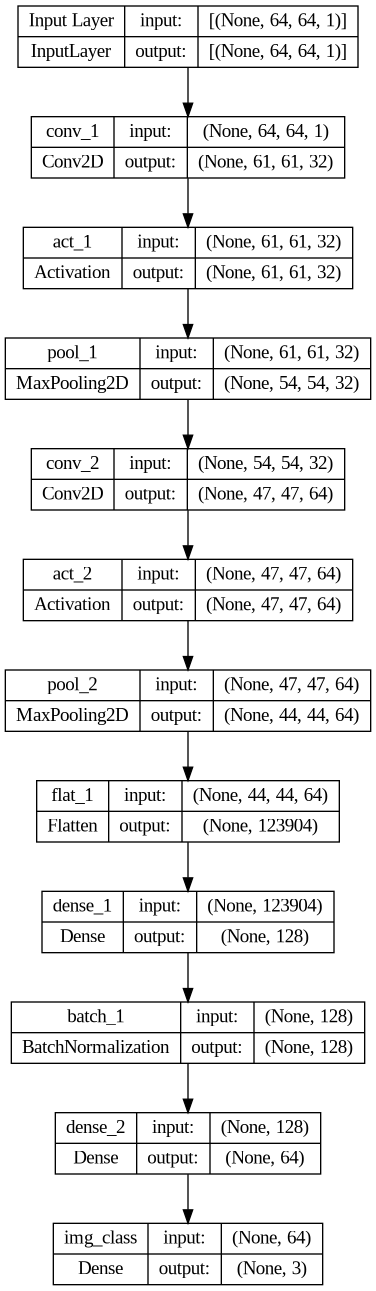

In [13]:
keras.utils.plot_model(model, "anomaly_cnn.png", show_shapes=True, show_layer_names=True)

In [14]:
_ = model.fit_generator(
        generator=train_batch_gen,
        steps_per_epoch=int(260 // batch_size),
        epochs=100,
        validation_data=test_batch_gen,
        validation_steps=int(65 // batch_size)
    )

/tmp/ipykernel_44412/2480808009.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  _ = model.fit_generator(
/tmp/ipykernel_44412/3675940926.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch_x = self.img_files[idx * self.batch_size : (idx + 1) * self.batch_size]


Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 1.7142 - accuracy: 0.3684 - val_loss: 1.6924 - val_accuracy: 0.1562
Epoch 2/100
8/8 [==============================] - 8s 935ms/step - loss: 1.2851 - accuracy: 0.5000 - val_loss: 1.3698 - val_accuracy: 0.3438
Epoch 3/100
8/8 [==============================] - 8s 936ms/step - loss: 1.2544 - accuracy: 0.6053 - val_loss: 1.2737 - val_accuracy: 0.7031
Epoch 4/100
8/8 [==============================] - 8s 989ms/step - loss: 1.4202 - accuracy: 0.5132 - val_loss: 1.1511 - val_accuracy: 0.7031
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 1.2581 - accuracy: 0.6016 - val_loss: 1.2322 - val_accuracy: 0.7031
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 1.4212 - accuracy: 0.5938 - val_loss: 1.0619 - val_accuracy: 0.4531
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 1.8845 - accuracy: 0.5439 - val_loss: 6.2484 - val_accuracy: 0.1250
Epoch 8/100
8/8 [=======

In [ ]:
res = cv2.resize(img, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)